In [81]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from numpy import linalg as LA
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.operators import Operator
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, transpile
from IPython.display import clear_output
from tqdm import trange
from scipy.optimize import minimize
import numpy.random as nrd

modified from TFIM_OICD_noisy.ipynb

# generate Hamiltonian

we consider the transverse-field Ising model,

$$
H=J \sum_{j=1}^{N-1} Z_j Z_{j+1}+\Delta \sum_{j=1}^N X_j
$$

with the coefficient $J=1$ and $\Delta=1.5$. Here $N$ denotes the number of qubits, and $X_j, Z_j$ are Pauli operators acting on the $j$-th qubit.


In [82]:
num_q = 8 ##

# parameters for setting up the Hamiltonian
J = 1
Delta = 1.5

# set H1
List_1 = []
for i in range(num_q-1):
    op = ""
    for k in range(i): # I's before ZZ
        op += "I"
    op += "ZZ"
    for k in range(i+1,num_q-1): # I's after ZZ
        op += "I"
    List_1.append(op)

List_1.reverse()
# example:
# for num_q = 5, List_1 = ['IIIZZ', 'IIZZI', 'IZZII', 'ZZIII']

H1 = SparsePauliOp(List_1, J*np.ones(num_q-1))  

# set H2
List_2 = []
for i in range(num_q):
    op = ""
    for k in range(i):
        op += "I"
    op += "X"
    for k in range(i+1,num_q):
        op += "I"
    List_2.append(op)
H2 = SparsePauliOp(List_2, Delta*np.ones(num_q))

# set H = H1 + H2
H = SparsePauliOp.sum([H1,H2])
Hmat = Operator(H)
Hmat = Hmat.data # This is the matrix representation of the Hamiltonian
# Ordering in SparsePauliOp e.g. IIIIIIZZ is the measurement of Z gates on the first 
# two qubits and so forth.

e, v = LA.eig(Hmat) # Compute the eigenvalues and right eigenvectors of a square array.
min_index = np.argmin(e)
v_min = v[:,min_index] # ground state (eigenvector)
ground_e = np.min(e) # ground state energy

# print(H[-1])
print(ground_e)
print(H.size)
print(H)
# print(H.paulis)
# print(H.paulis[0])

(-13.191404952188934+0j)
15
SparsePauliOp(['IIIIIIZZ', 'IIIIIZZI', 'IIIIZZII', 'IIIZZIII', 'IIZZIIII', 'IZZIIIII', 'ZZIIIIII', 'XIIIIIII', 'IXIIIIII', 'IIXIIIII', 'IIIXIIII', 'IIIIXIII', 'IIIIIXII', 'IIIIIIXI', 'IIIIIIIX'],
              coeffs=[1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1.5+0.j,
 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j, 1.5+0.j])


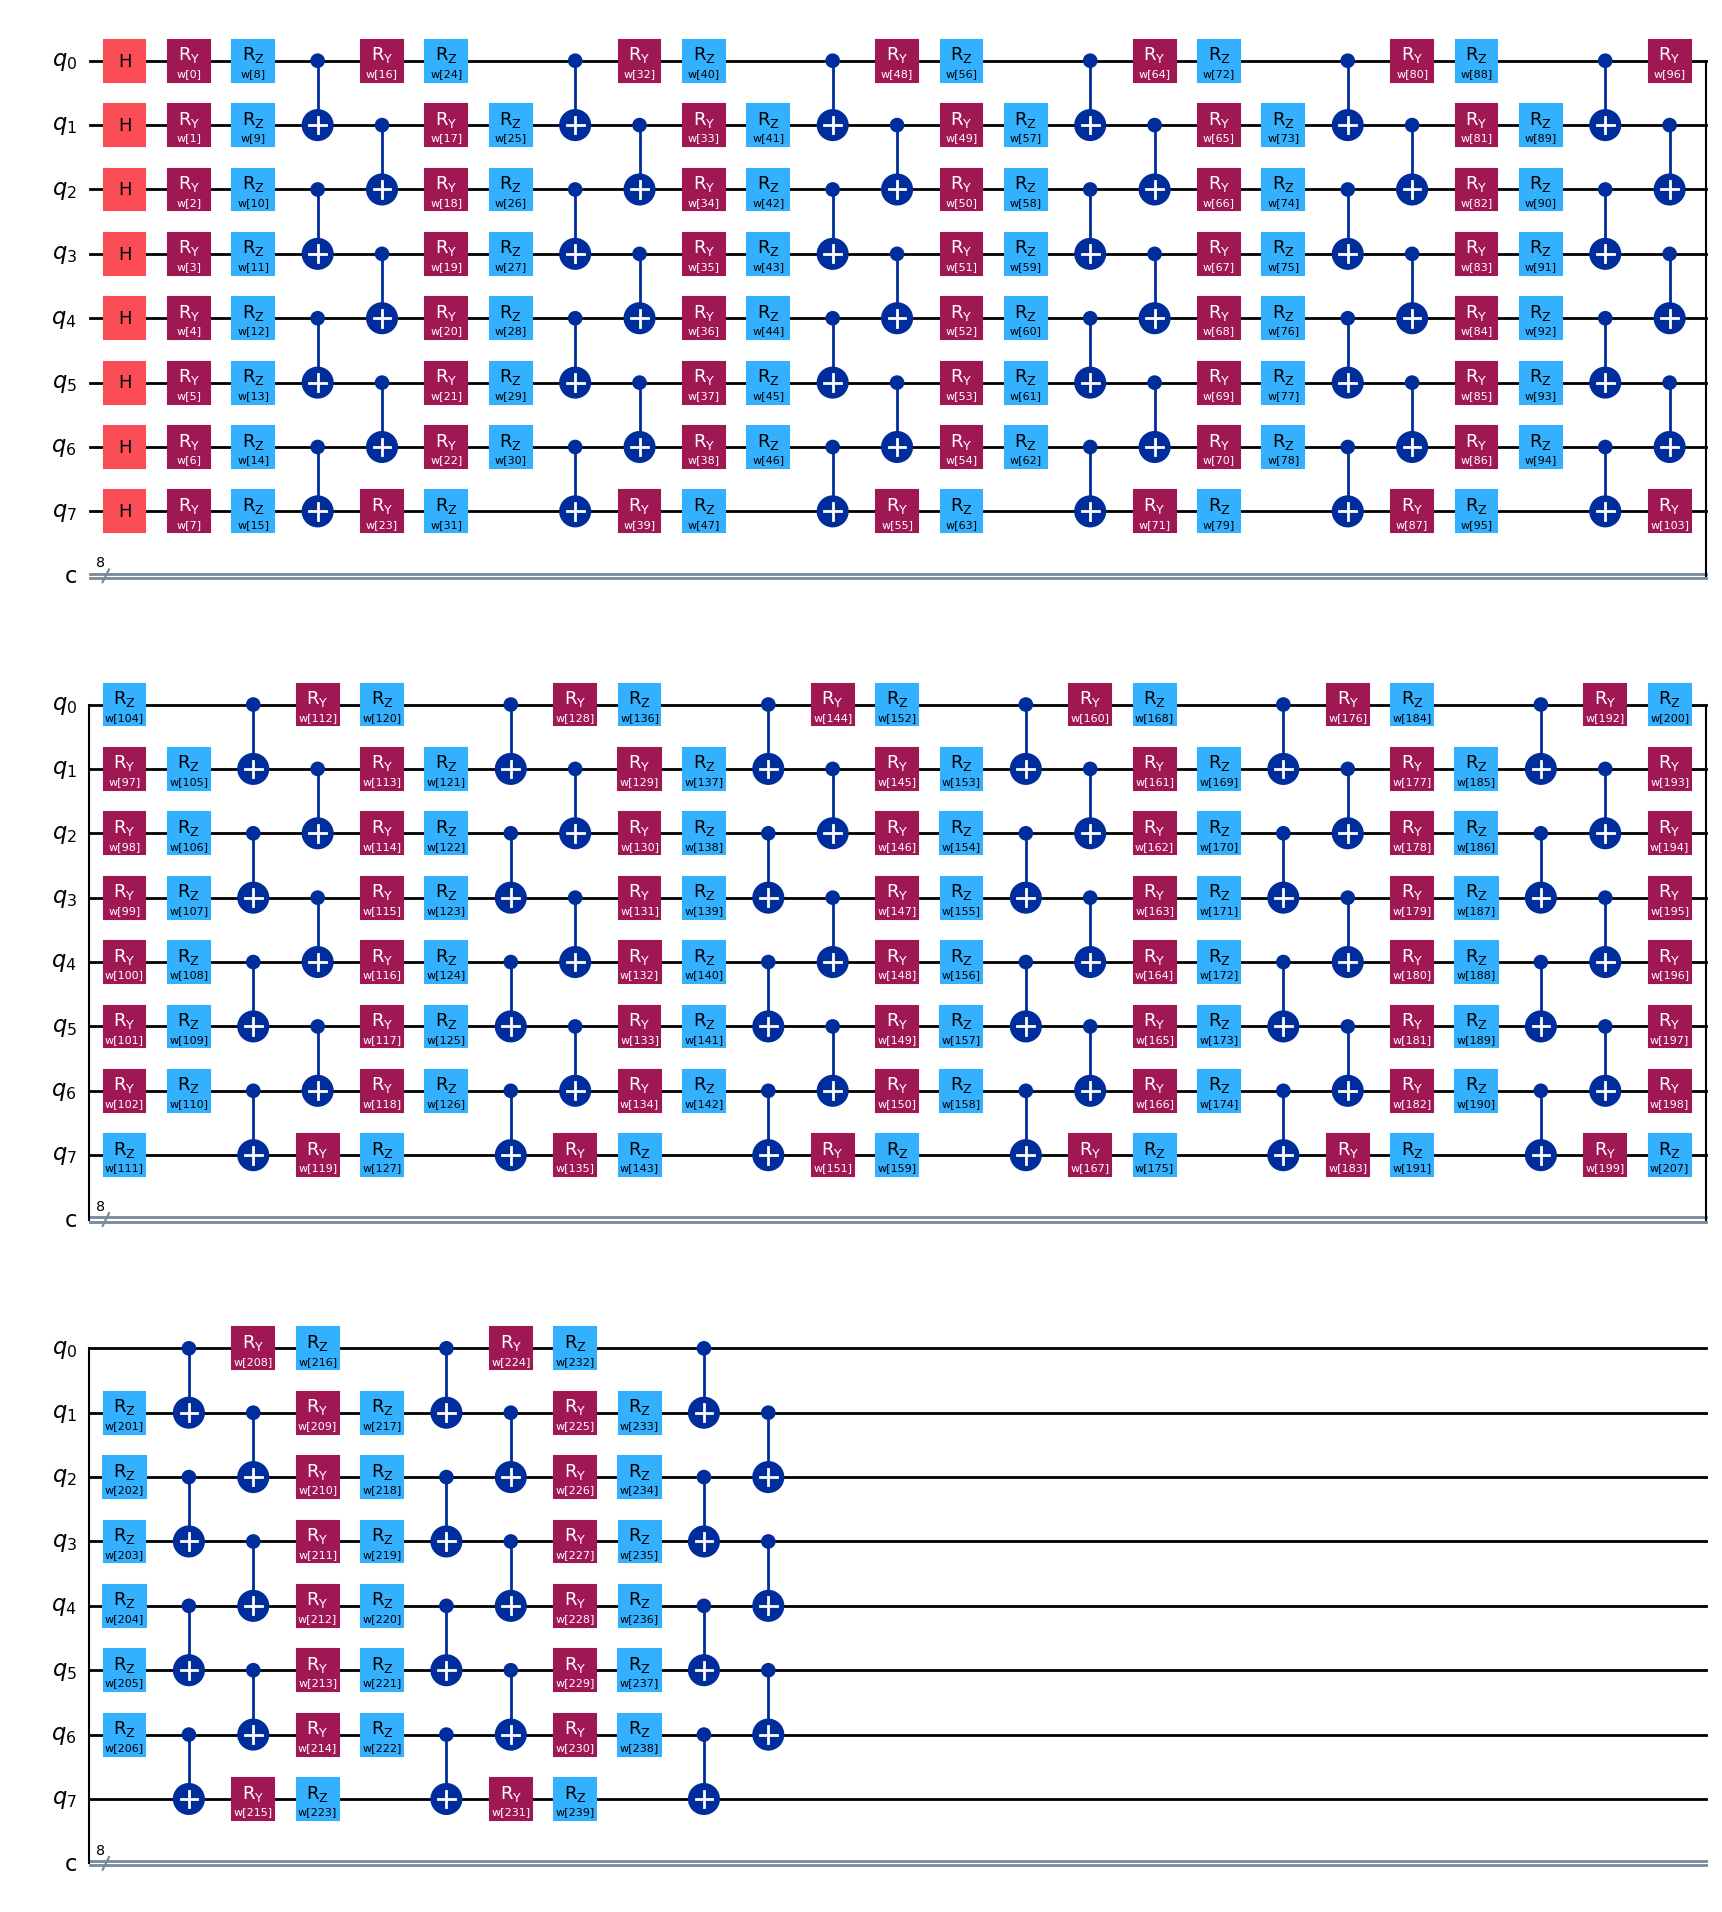

In [83]:
"""circuit construction"""

layer = 15 ##

num_p = 2*layer*num_q
weights = ParameterVector("w",num_p)

def circuit_ex(weights):
    circ = QuantumCircuit(num_q, num_q)
    for j in range(num_q):
        circ.h(j)
    for i in range(layer):
        for j in range(num_q):
            circ.ry(weights[2*i*num_q+j],j)
        for j in range(num_q):
            circ.rz(weights[2*i*num_q+num_q+j],j)
        for j in range(int(num_q/2)):
            circ.cx(2*j,2*j+1)
        for j in range(int(num_q/2)-1):
            circ.cx(2*j+1,2*j+2)
    return circ

qc=circuit_ex(weights)
qc.draw('mpl')


In [84]:
print(H1.paulis)
print(H2.paulis)

['IIIIIIZZ', 'IIIIIZZI', 'IIIIZZII', 'IIIZZIII', 'IIZZIIII', 'IZZIIIII',
 'ZZIIIIII']
['XIIIIIII', 'IXIIIIII', 'IIXIIIII', 'IIIXIIII', 'IIIIXIII', 'IIIIIXII',
 'IIIIIIXI', 'IIIIIIIX']


In [85]:
simulator = AerSimulator()

def estimate_loss(WEIGHTS, SHOTS):
    # estimate for ZZ gates in H1
    estimate = 0
    qc = circuit_ex(WEIGHTS)
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc) 
    for i in range(SHOTS):
        for j in range(num_q-1):
            if c[i][num_q-1-j] == c[i][num_q-1-(j+1)]:
            # if c[i][j] == c[i][j+1]:
                estimate += 1
            else:
                estimate += -1
    estimate = J*estimate/SHOTS
    
    # estimate_1 for X gates in H2
    estimate_1 = 0
    qc = circuit_ex(WEIGHTS)
    for i in range(num_q):
        qc.h(i)
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc)
    for i in range(SHOTS):
        for j in range(num_q):
            if c[i][num_q-1-j] == '0':
            # if c[i][j] == '0':
                estimate_1 += 1
            else:
                estimate_1 += -1
    estimate_1 = Delta*estimate_1/SHOTS
    
    # sum of estimate and estimate_1 for H
    return estimate+estimate_1

def expectation_loss(WEIGHTS):
    qc = circuit_ex(WEIGHTS)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    # ==========================================================================
    Hpsi = Hmat.dot(psi)
    expectation = np.inner(np.conjugate(psi),Hpsi)
    return np.real(expectation)

def fidelity(WEIGHTS):
    qc = circuit_ex(WEIGHTS)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    # ==========================================================================
    return np.absolute(np.vdot(psi,v_min))**2

def OICD_estimate(WEIGHTS, INDEX, SHOTS): # use estimate_loss
    identity = np.identity(num_p)
    direction_index = -WEIGHTS[INDEX] *identity[:,INDEX] 
    f_zero = estimate_loss((WEIGHTS + direction_index.flatten()), SHOTS)  
 
    direction_index = (-WEIGHTS[INDEX]+np.pi/2) *identity[:,INDEX]
    f_half_pi = estimate_loss((WEIGHTS + direction_index.flatten()), SHOTS)  
 
    direction_index = (-WEIGHTS[INDEX]+np.pi) *identity[:,INDEX]
    f_pi = estimate_loss((WEIGHTS + direction_index.flatten()), SHOTS)
    
    a = 0.5*(f_zero + f_pi)
    b = 0.5*(f_zero - f_pi)
    c = f_half_pi - a
    
    value = np.arctan2(b,c)
    return -np.pi/2 - value 


def parameter_shift(WEIGHTS, INDEX, SHOTS):
    identity = np.identity(num_p)
    direction_index = np.pi/2 *identity[:,INDEX] ## parameter shift rule with eigenvalues +-0.5
    g_p = estimate_loss((WEIGHTS+direction_index.flatten()), SHOTS)  
    g_m = estimate_loss((WEIGHTS-direction_index.flatten()), SHOTS)
    g = 0.5*(g_p-g_m) ## parameter shift rule with eigenvalues +-0.5
    return g



In [86]:

def update_for_frequency_1(a, b, c, approx_loss, opt_goal):
    # The goal here is to find the analytic solution of approx_loss, not exact_single_var_fun
    # And the solution should be within 0 to 2*pi
    if np.isclose(b, 0) and np.isclose(c, 0):
        # Constant function. Any value is an extrema, so it remains unchanged.
        updated_weight = 0.0
    elif np.isclose(b, 0) and not np.isclose(c, 0):
        # sin function, extrema influenced by amplitude c
        if opt_goal == 'max':
            updated_weight = (np.pi / 2) if c > 0 else (3 * np.pi / 2)
        elif opt_goal == 'min':
            updated_weight = (3 * np.pi / 2) if c > 0 else (np.pi / 2)
    elif np.isclose(c, 0) and not np.isclose(b, 0):
        # cos function, extrema influenced by amplitude b
        if opt_goal == 'max':
            updated_weight = 0.0 if b > 0 else np.pi
        elif opt_goal == 'min':
            updated_weight = np.pi if b > 0 else 0.0
    else: # not np.isclose(c, 0) and not np.isclose(b, 0)
        updated_weight = np.arctan(c / b)
        IS_MAXIMIZER = approx_loss(updated_weight) > a
        IS_POSITIVE = updated_weight > 0
        if opt_goal == 'max':
            if IS_POSITIVE:
                if not IS_MAXIMIZER:
                    updated_weight += np.pi
            else:
                if IS_MAXIMIZER:
                    updated_weight += 2 * np.pi
                else:
                    updated_weight += np.pi
        elif opt_goal == 'min':
            if IS_POSITIVE:
                if IS_MAXIMIZER:
                    updated_weight += np.pi
            else:
                if IS_MAXIMIZER:
                    updated_weight += np.pi
                else:
                    updated_weight += 2 * np.pi
    
    approx_loss_value = approx_loss(updated_weight)

    return updated_weight, approx_loss_value

def construct_Es_inv(s, omegas):
    # 计算旋转矩阵 B_i^T
    num_blocks = len(omegas) + 1  # 第一块是 1x1 矩阵 [1]，之后每个块为 2x2 矩阵
    total_size = num_blocks * 2 - 1  # 计算总大小
    
    # 初始化一个全零矩阵，大小为 total_size x total_size
    E_s_inv = np.zeros((total_size, total_size))
    
    # 设置第一块 1x1 矩阵
    E_s_inv[0, 0] = 1
    
    # 填充后续的旋转矩阵块 B_i^T
    for i, Omega_i in enumerate(omegas):
        # 构造每个 B_i
        B_i = np.array([[np.cos(Omega_i * s), np.sin(Omega_i * s)],
                        [-np.sin(Omega_i * s), np.cos(Omega_i * s)]])
        # 将 B_i^T 填入矩阵 E_s_inv
        E_s_inv[2*i+1:2*i+3, 2*i+1:2*i+3] = B_i.T
    
    return E_s_inv

# example: when omega = [1]
# E_s_inv = np.array([[1, 0, 0], 
#                     [0, np.cos(omegas[0] * shift), - np.sin(omegas[0] * shift)], 
#                     [0, np.sin(omegas[0] * shift), np.cos(omegas[0] * shift)]])


def oicd(estimate_loss, n_shot, weights_dict, init_weights, num_iters,
                             opt_goal='min', 
                             cyclic_mode=False, 
                             use_solvers_flag = True,
                             subproblem_iter=20,
                             use_vanila_interp_flag=False):
    
    weights = init_weights
    loss = estimate_loss(weights, n_shot) 
    # loss = expectation_loss(weights) ## excat OICD
    approx_loss_value = loss
    expected_record_value = []
    fidelity_record_value = []
    approx_record_value = []

    print("-"*100)
    
    t = trange(num_iters, desc="Bar desc", leave=True)
    m = len(weights)

    for i in t:

        if cyclic_mode:
            j = i % m
        else:
            j = np.random.randint(m)

        # read the things for interpolation
        omegas = weights_dict[f'weights_{j}']['omegas']
        interp_nodes = weights_dict[f'weights_{j}']["interp_nodes"]
        inv_A = weights_dict[f'weights_{j}']['inverse_interp_matrix']
        
        # execute interpolation
        if use_vanila_interp_flag:
            #  Vanilla OICD Method in Algorithm 2 in paper
            fun_vals = []
            weights_copy = weights.copy()
            for node in interp_nodes: 
                weights_copy[j] = node
                fun_val = estimate_loss(weights_copy, n_shot)
                # fun_val = expectation_loss(weights_copy) ## excat OICD
                fun_vals.append(fun_val)
            fun_vals = np.array(fun_vals)
            reco_coef = inv_A @ fun_vals
        else:
            # Practical OICD Method in Algorithm 3 in paper
            shift = weights[j] - interp_nodes[0]
            shifted_interp_nodes = interp_nodes + shift
            E_s_inv = construct_Es_inv(shift, omegas)
            fun_vals = [approx_loss_value]
            weights_copy = weights.copy()
            for node in shifted_interp_nodes[1:]:
                weights_copy[j] = node
                fun_val = estimate_loss(weights_copy, n_shot)
                # fun_val = expectation_loss(weights_copy) ## excat OICD
                fun_vals.append(fun_val)
            fun_vals = np.array(fun_vals)
            reco_coef = E_s_inv @ (inv_A @ fun_vals)

        # construct the approximate loss function
        r= len(omegas)
        def approx_loss(x): # approx_loss
            trig_x_term = np.array([1 / np.sqrt(2)] + [func(omegas[k] * x).item() for k in range(r) for func in (np.cos, np.sin)])
            return np.dot(trig_x_term, reco_coef)
       
        # solve the subproblem: min/max approx_loss(x)
        if use_solvers_flag: 
            # use optimization solvers for subproblem
            if opt_goal == 'max':
                fun_handle = lambda x: - approx_loss(x)
            else:
                fun_handle = approx_loss
            options = {'maxiter': subproblem_iter, 'disp': False}
            # IMPORTANT TIP: initial guess is set as the current coordinate value
            initial_guess = weights[j]  
            result = minimize(fun_handle, initial_guess, options=options)
            # obtain the solution and loss value
            updated_weight = result.x.item() 
            approx_loss_value = -result.fun if opt_goal == 'max' else result.fun
        else:
            # only for case of omega = [1], 
            # we directly compute the analytical solution
            a = reco_coef[0]/np.sqrt(2)
            b = reco_coef[1]
            c = reco_coef[2]
            updated_weight, approx_loss_value = update_for_frequency_1(a, b, c, approx_loss, opt_goal)
    
        weights[j] = updated_weight

        true_loss = expectation_loss(weights)
        fid = fidelity(weights)
        approx_record_value.append(approx_loss_value)
        expected_record_value.append(true_loss)
        fidelity_record_value.append(fid)
    
        message = f"Iter: {i}, True loss: {true_loss}, Fidelity: {fid}, Coord j: {j}({m})"
        t.set_description(f"[OICD] %s" % message)
        t.refresh()

        clear_output(wait=True)
        plt.plot(approx_record_value, label='Approx Loss')
        plt.plot(expected_record_value, label='True Loss')
        plt.xlabel('iteration')
        plt.title('OICD')
        plt.legend()
        plt.show()

    print(f"[OICD] Final expectation loss:", true_loss)

    return weights, expected_record_value, fidelity_record_value


In [87]:
# from check_utils import check_is_trigometric
# weights = np.random.normal(0, 4*np.pi**2, num_p)
# for j in range(num_p):
#     # Circuit_HEA is simple and all Hermitian generators are Y.
#     omegas=[1] # 这个需要更具电路来决定
#     print('\n index to check = ',j)
#     print('omegas = ', omegas)
#     opt_interp_flag = False
#     check_is_trigometric(expectation_loss, j, omegas, weights, opt_interp_flag)
#     # print('\n')

In [88]:

def update_for_frequency_1(a, b, c, approx_loss, opt_goal):
    # The goal here is to find the analytic solution of approx_loss, not exact_single_var_fun
    # And the solution should be within 0 to 2*pi
    if np.isclose(b, 0) and np.isclose(c, 0):
        # Constant function. Any value is an extrema, so it remains unchanged.
        updated_weight = 0.0
    elif np.isclose(b, 0) and not np.isclose(c, 0):
        # sin function, extrema influenced by amplitude c
        if opt_goal == 'max':
            updated_weight = (np.pi / 2) if c > 0 else (3 * np.pi / 2)
        elif opt_goal == 'min':
            updated_weight = (3 * np.pi / 2) if c > 0 else (np.pi / 2)
    elif np.isclose(c, 0) and not np.isclose(b, 0):
        # cos function, extrema influenced by amplitude b
        if opt_goal == 'max':
            updated_weight = 0.0 if b > 0 else np.pi
        elif opt_goal == 'min':
            updated_weight = np.pi if b > 0 else 0.0
    else: # not np.isclose(c, 0) and not np.isclose(b, 0)
        updated_weight = np.arctan(c / b)
        IS_MAXIMIZER = approx_loss(updated_weight) > a
        IS_POSITIVE = updated_weight > 0
        if opt_goal == 'max':
            if IS_POSITIVE:
                if not IS_MAXIMIZER:
                    updated_weight += np.pi
            else:
                if IS_MAXIMIZER:
                    updated_weight += 2 * np.pi
                else:
                    updated_weight += np.pi
        elif opt_goal == 'min':
            if IS_POSITIVE:
                if IS_MAXIMIZER:
                    updated_weight += np.pi
            else:
                if IS_MAXIMIZER:
                    updated_weight += np.pi
                else:
                    updated_weight += 2 * np.pi
    
    approx_loss_value = approx_loss(updated_weight)

    return updated_weight, approx_loss_value

def construct_Es_inv(s, omegas):
    # 计算旋转矩阵 B_i^T
    num_blocks = len(omegas) + 1  # 第一块是 1x1 矩阵 [1]，之后每个块为 2x2 矩阵
    total_size = num_blocks * 2 - 1  # 计算总大小
    
    # 初始化一个全零矩阵，大小为 total_size x total_size
    E_s_inv = np.zeros((total_size, total_size))
    
    # 设置第一块 1x1 矩阵
    E_s_inv[0, 0] = 1
    
    # 填充后续的旋转矩阵块 B_i^T
    for i, Omega_i in enumerate(omegas):
        # 构造每个 B_i
        B_i = np.array([[np.cos(Omega_i * s), np.sin(Omega_i * s)],
                        [-np.sin(Omega_i * s), np.cos(Omega_i * s)]])
        # 将 B_i^T 填入矩阵 E_s_inv
        E_s_inv[2*i+1:2*i+3, 2*i+1:2*i+3] = B_i.T
    
    return E_s_inv

# example: when omega = [1]
# E_s_inv = np.array([[1, 0, 0], 
#                     [0, np.cos(omegas[0] * shift), - np.sin(omegas[0] * shift)], 
#                     [0, np.sin(omegas[0] * shift), np.cos(omegas[0] * shift)]])


def oicd(estimate_loss, n_shot, weights_dict, init_weights, num_iters,
                             opt_goal='min', 
                             subproblem_method='CG',
                             subproblem_iter=20,
                             cyclic_mode=False,
                             use_solvers_flag = True,
                             use_vanila_interp_flag=False):
    
    weights = init_weights
    loss = estimate_loss(weights, n_shot) 
    # loss = expectation_loss(weights) ## excat OICD
    approx_loss_value = loss
    expected_record_value = []
    fidelity_record_value = []
    approx_record_value = []

    print("-"*100)
    
    t = trange(num_iters, desc="Bar desc", leave=True)
    m = len(weights)

    for i in t:

        if cyclic_mode:
            j = i % m
        else:
            j = np.random.randint(m)

        # read the things for interpolation
        omegas = weights_dict[f'weights_{j}']['omegas']
        interp_nodes = weights_dict[f'weights_{j}']["interp_nodes"]
        inv_A = weights_dict[f'weights_{j}']['inverse_interp_matrix']
        
        # execute interpolation
        if use_vanila_interp_flag:
            #  Vanilla OICD Method in Algorithm 2 in paper
            fun_vals = []
            weights_copy = weights.copy()
            for node in interp_nodes: 
                weights_copy[j] = node
                fun_val = estimate_loss(weights_copy, n_shot)
                # fun_val = expectation_loss(weights_copy) ## excat OICD
                fun_vals.append(fun_val)
            fun_vals = np.array(fun_vals)
            reco_coef = inv_A @ fun_vals
        else:
            # Practical OICD Method in Algorithm 3 in paper
            shift = weights[j] - interp_nodes[0]
            shifted_interp_nodes = interp_nodes + shift
            E_s_inv = construct_Es_inv(shift, omegas)
            fun_vals = [approx_loss_value]
            weights_copy = weights.copy()
            for node in shifted_interp_nodes[1:]:
                weights_copy[j] = node
                fun_val = estimate_loss(weights_copy, n_shot)
                # fun_val = expectation_loss(weights_copy) ## excat OICD
                fun_vals.append(fun_val)
            fun_vals = np.array(fun_vals)
            reco_coef = E_s_inv @ (inv_A @ fun_vals)

        # construct the approximate loss function
        r= len(omegas)
        def approx_loss(x): # approx_loss
            trig_x_term = np.array([1 / np.sqrt(2)] + [func(omegas[k] * x).item() for k in range(r) for func in (np.cos, np.sin)])
            return np.dot(trig_x_term, reco_coef)
       
        # solve the subproblem: min/max approx_loss(x)
        if use_solvers_flag: 
            # use optimization solvers for subproblem
            if opt_goal == 'max':
                fun_handle = lambda x: - approx_loss(x)
            else:
                fun_handle = approx_loss
            options = {'maxiter': subproblem_iter,
                    'method' : subproblem_method,
                    'disp': False}
            # IMPORTANT TIP: initial guess is set as the current coordinate value
            initial_guess = weights[j]
            # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
            # The default method is BFGS.
            # minimize can receive gradient and hessian           
            result = minimize(fun_handle, initial_guess, options=options)
            # obtain the solution and loss value
            updated_weight = result.x.item() 
            approx_loss_value = -result.fun if opt_goal == 'max' else result.fun
        else:
            # only for case of omega = [1], 
            # we directly compute the analytical solution
            a = reco_coef[0]/np.sqrt(2)
            b = reco_coef[1]
            c = reco_coef[2]
            updated_weight, approx_loss_value = update_for_frequency_1(a, b, c, approx_loss, opt_goal)
    
        weights[j] = updated_weight

        true_loss = expectation_loss(weights)
        fid = fidelity(weights)
        approx_record_value.append(approx_loss_value)
        expected_record_value.append(true_loss)
        fidelity_record_value.append(fid)
    
        message = f"Iter: {i}, True loss: {true_loss}, Fidelity: {fid}, Coord j: {j}({m})"
        t.set_description(f"[OICD] %s" % message)
        t.refresh()

        # clear_output(wait=True)
        # plt.plot(approx_record_value, label='Approx Loss')
        # plt.plot(expected_record_value, label='True Loss')
        # plt.xlabel('iteration')
        # plt.title('OICD')
        # plt.legend()
        # plt.show()

        clear_output(wait=True)

        # 创建 1 行 2 列的子图
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        # 绘制 Approx Loss 和 True Loss 在第一个子图
        axs[0].plot(approx_record_value, label='Approx Loss')
        axs[0].plot(expected_record_value, label='True Loss')
        axs[0].set_xlabel('Iteration')
        axs[0].set_title('OICD Loss')
        axs[0].legend(fontsize=12)

        # 绘制 Fidelity 在第二个子图
        axs[1].plot(fidelity_record_value, label='Fidelity', color='g')
        axs[1].axhline(y=1, color='r', linestyle='--', label='1')
        axs[1].set_xlabel('Iteration')
        axs[1].set_title('Fidelity')
        axs[1].legend(fontsize=12)

        # 显示图像
        plt.tight_layout()  # 自动调整子图间的间距
        plt.show()

    print(f"[OICD] Final expectation loss:", true_loss)

    return weights, expected_record_value, fidelity_record_value


In [89]:
from check_utils import interp_matrix

weights_dict = {}
omegas = [1]
interp_nodes = np.linspace(0,2*np.pi,2*len(omegas)+1,endpoint=False)
inverse_interp_matrix = np.linalg.inv(interp_matrix(interp_nodes, omegas))
for i in range(num_p):
    weights_dict[f'weights_{i}'] = {
        'omegas': [1],
        'interp_nodes': interp_nodes,
        'inverse_interp_matrix': inverse_interp_matrix,
    }

print(weights_dict['weights_0'])
print(f'true ground state energy:',ground_e)

{'omegas': [1], 'interp_nodes': array([0.       , 2.0943951, 4.1887902]), 'inverse_interp_matrix': array([[ 4.71404521e-01,  4.71404521e-01,  4.71404521e-01],
       [ 6.66666667e-01, -3.33333333e-01, -3.33333333e-01],
       [-1.92296269e-16,  5.77350269e-01, -5.77350269e-01]])}
true ground state energy: (-13.191404952188934+0j)


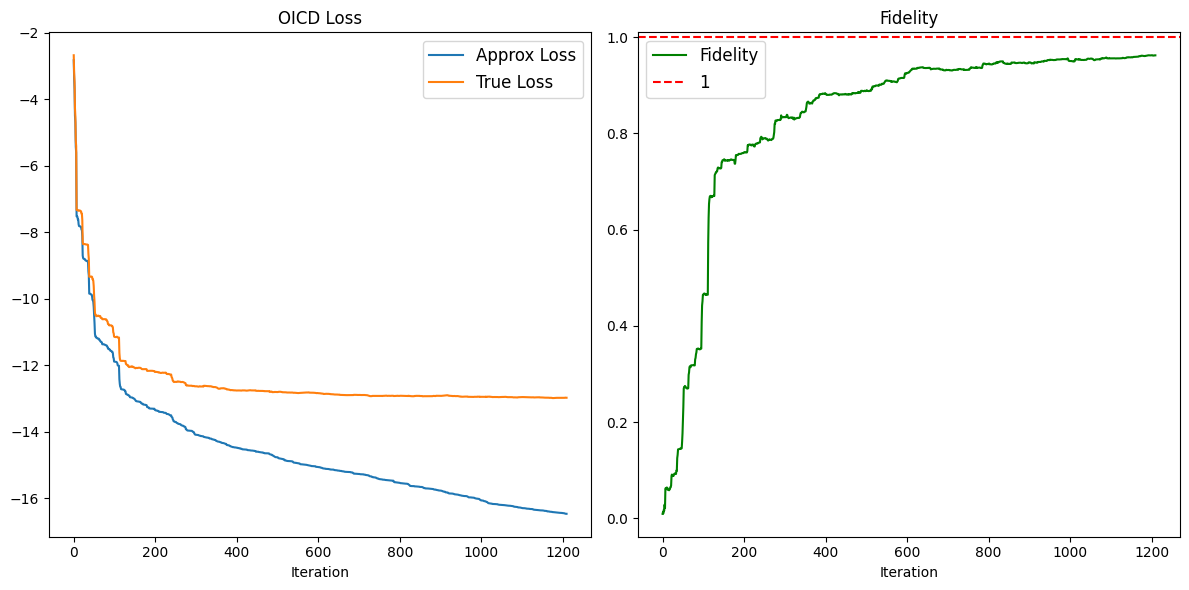

[OICD] Iter: 1209, True loss: -12.977564076082237, Fidelity: 0.962467199377387, Coord j: 9(240):  24%|██▍       | 1210/5000 [18:27<57:48,  1.09it/s]


KeyboardInterrupt: 

In [90]:
"""optimization phase"""

mat = scipy.io.loadmat('w0')
w0 = mat['w0']

initial_weights = np.zeros(num_p) #np.ones(num_p)
initial_weights[:10] = w0.flatten()
# initial_weights = np.random.uniform(0, 2*np.pi, size=num_p)

num_iters = 5000
n_shot = 1000

# Run OICD
final_weights, expected_record_value, fidelity_record_value = oicd(
    estimate_loss, n_shot, weights_dict, initial_weights, num_iters,
    opt_goal  ='min',
    subproblem_method = 'CG', # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
    subproblem_iter = 20,
    cyclic_mode = True,
    use_solvers_flag = False,
    use_vanila_interp_flag = False,
)

# plt.plot(expected_record_value)
# plt.xlabel('iteration')
# plt.title('OICD')
# plt.show()